In [2]:
import math
from math import tanh
import numpy as np
def s_curves1(t, x4):
    """
        Unit hydrograph ordinates for UH1 derived from S-curves.
    """

    if t <= 0:
        return 0
    elif t < x4:
        return (t/x4)**2.5
    else: # t >= x4
        return 1


def s_curves2(t, x4):
    """
        Unit hydrograph ordinates for UH2 derived from S-curves.
    """

    if t <= 0:
        return 0
    elif t < x4:
        return 0.5*(t/x4)**2.5
    elif t < 2*x4:
        return 1 - 0.5*(2 - t/x4)**2.5
    else: # t >= x4
        return 1


def gr4j(precip, potential_evap, params, states = None, return_state = False):
    """
        Generated simulated streamflow for given rainfall and potential evaporation.

        :param precip: Catchment average rainfall.
        :type precip: array(float)
        :param potential_evap: Catchment average potential evapotranspiration.
        :type potential_evap: array(float)
        :param params: X parameters for the model.
        :type params: dictionary with keys X1, X2, X3, X4
        :param states: Optional initial state values.
        :type states: Dictionary with optional keys 'production_store', 'routing_store'.
        :param return_state: If true returns a dictionary containing 'production_store' and 'routing_store'. Default: False.
        :type return_state: boolean

        :return: Array of simulated streamflow.
    """
    if states is None:
        states = {}

    X1 = params['X1']
    X2 = params['X2']
    X3 = params['X3']
    X4 = params['X4']

    nUH1 = int(math.ceil(X4))
    nUH2 = int(math.ceil(2.0*X4))

    uh1_ordinates = [0] * nUH1
    uh2_ordinates = [0] * nUH2

    UH1 = states.get('UH1', [0] * nUH1)
    UH2 = states.get('UH2', [0] * nUH2)

    for t in range(1, nUH1 + 1):
        uh1_ordinates[t - 1] = s_curves1(t, X4) - s_curves1(t-1, X4)

    for t in range(1, nUH2 + 1):
        uh2_ordinates[t - 1] = s_curves2(t, X4) - s_curves2(t-1, X4)

    production_store = states.get('production_store', 0) # S
    routing_store = states.get('routing_store', 0) # R

    qsim = []
    for P, E in zip(precip, potential_evap):

        if P > E:
            net_evap = 0
            scaled_net_precip = (P - E)/X1
            if scaled_net_precip > 13:
                scaled_net_precip = 13
            tanh_scaled_net_precip = tanh(scaled_net_precip)
            reservoir_production = (X1 * (1 - (production_store/X1)**2) * tanh_scaled_net_precip) / (1 + production_store/X1 * tanh_scaled_net_precip)

            routing_pattern = P-E-reservoir_production
        else:
            scaled_net_evap = (E - P)/X1
            if scaled_net_evap > 13:
                scaled_net_evap = 13.
            tanh_scaled_net_evap = tanh(scaled_net_evap)

            ps_div_x1 = (2 - production_store/X1) * tanh_scaled_net_evap
            net_evap = production_store * (ps_div_x1) / \
                    (1 + (1 - production_store/X1) * tanh_scaled_net_evap)

            reservoir_production = 0
            routing_pattern = 0

        production_store = production_store - net_evap + reservoir_production

        percolation = production_store / (1 + (production_store/2.25/X1)**4)**0.25

        routing_pattern = routing_pattern + (production_store-percolation)
        production_store = percolation


        for i in range(0, len(UH1) - 1):
            UH1[i] = UH1[i+1] + uh1_ordinates[i]*routing_pattern
        UH1[-1] = uh1_ordinates[-1] * routing_pattern

        for j in range(0, len(UH2) - 1):
            UH2[j] = UH2[j+1] + uh2_ordinates[j]*routing_pattern
        UH2[-1] = uh2_ordinates[-1] * routing_pattern

        groundwater_exchange = X2 * (routing_store / X3)**3.5
        routing_store = max(0, routing_store + UH1[0] * 0.9 + groundwater_exchange)

        R2 = routing_store / (1 + (routing_store / X3)**4)**0.25
        QR = routing_store - R2
        routing_store = R2
        QD = max(0, UH2[0]*0.1+groundwater_exchange)
        Q = QR + QD

        qsim.append(Q)

    if return_state:
        return qsim, {
            'production_store': production_store,
            'routing_store': routing_store,
            'UH1': UH1,
            'UH2': UH2,
        }
    else:
        return qsim

def mean_absolute_error(y_true, y_pred):
   result = np.sum(np.abs(y_pred - y_true), axis=0) / len(y_true)
   return result

def mean_squared_error( y_true, y_pred):
   result = np.sum((y_pred - y_true) ** 2, axis=0) / len(y_true)
   return result

def root_mean_squared_error( y_true, y_pred):
   result = np.sqrt(np.sum((y_pred - y_true) ** 2, axis=0) / len(y_true))
   return result

def  median_absolute_error( y_true, y_pred):
   result = np.median(np.abs(y_true - y_pred), axis=0)
   return result
def nash_sutcliffe_efficiency( y_true, y_pred):
   result = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)   
   return result
def coefficient_of_determination( y_true, y_pred):
    result =  np.sum((y_pred - np.mean(y_pred, axis=0)) ** 2, axis=0) / np.sum((y_true - np.mean(y_pred, axis=0)) ** 2, axis=0)
    return result
   



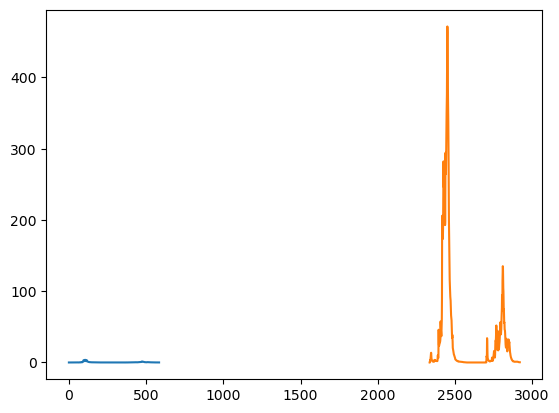

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data = pd.read_csv('beterou_62_72_cal.csv') 
data.columns = ['Dates','Prec','ETP','Debit']
cal_data, val_data = train_test_split(data, test_size=0.2, shuffle=False)



params = { 'X1': 235.32, 'X2': -19.99, 'X3': 199.99, 'X4':  2.73 }
#states = { 'production_store': 0.60 * params['X1'], 'routing_store': 0.70 * params['X3'] }
simulated_flow = gr4j(val_data['Prec'], val_data['ETP'], params)

plt.plot(np.array(simulated_flow))
#plt.plot(PEQ2['Q_obs(mm)'].reset_index())
plt.plot(val_data['Debit'])
plt.show()

In [ ]:


# Graphiques d'ensemble 
ax = plt.subplot(111)
ax.bar(time, p, width=10,color=[0,0.1,0.2] )
color = 'tab:red'
ax.xaxis_date()
ax.invert_yaxis()
ax.set_ylabel('Y1-axis', color = color)  
ax2 = ax.twinx()
color = 'tab:green'
ax2.set_ylabel('Y2-axis', color = color)  
ax2.plot(time,np.array(simulated_flow))
ax2.plot(time,Q['Q_obs(mm)'])
plt.show()



In [ ]:
time1 =  date.toordinal(date(daterange_validation[0].year,daterange_validation[0].month,daterange_validation[0].day))
time2 =  date.toordinal(date(daterange_validation[1].year,daterange_validation[1].month,daterange_validation[1].day))

time = np.arange(time1,time2+1)        

# Graphiques d'ensemble 
x = debits
abs = np.arange(len(x[0]))
p =data['Prec'].iloc[0:len(x[0])]
fig, ax = plt.subplots()
ax.bar(abs,p,color=[0,0.1,0.2] )
color = 'tab:red'
ax.xaxis_date()
ax.invert_yaxis()
ax.set_ylabel('Y1-axis', color = color) 
ax2 = ax.twinx()
color = 'tab:green'
ax2.set_ylabel('Y2-axis', color = color)  
ax2.plot(abs,x[1])
ax2.plot(abs,x[0])

ax.set_xlabel("Date in day")
ax.set_ylabel("Discharge")